In [1]:
from __future__ import print_function
import os
import neat

import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt



from explaneat.core.backprop import NeatNet
from explaneat.core import backprop
from explaneat.core.backproppop import BackpropPopulation
from explaneat.visualization import visualize
from explaneat.core.experiment import ExperimentReporter
from explaneat.core.utility import one_hot_encode


from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score



from copy import deepcopy

import time
from datetime import datetime


import gzip
try:
    import cPickle as pickle  # pylint: disable=import-error
except ImportError:
    import pickle  # pylint: disable=import-error

In [2]:

USE_CUDA = torch.cuda.is_available()
USE_CUDA = False
device = torch.device("cuda:1" if USE_CUDA else "cpu")
cuda_device = torch.device("cuda:1")

In [3]:
device

device(type='cpu')

# Iris Experiment

This experiment (a) test the experimental environment, but is also to evaluate the efficacy of the ExplaNEAT algorithm. Speed is a critical factor, as well as stability of results on population size. Total run time will also be measured

First, we need to set a random seed and a total stopping point in the number of generations

In [4]:
my_random_seed = 42
random.seed(my_random_seed)

In [5]:
def one_hot_encode(vals):
    width = max(vals)
    newVals = []
    for val in vals:
        blank = [0. for _ in range(width + 1)]
        blank[val] = 1.
        newVals.append(blank)
    return np.asarray(newVals)


## Dataset

We are going to work with the Iris dataset, which will be loaded from `sklearn`. We want to characterise the efficacy of the algorithm with regards to a mostly untransformed dataset, so we will only normalise the features

In [12]:
data = pd.read_csv('./../../data/house-prices/train.csv')

In [13]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [14]:
data.dtypes    

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [18]:
from sklearn.preprocessing import normalize, OneHotEncoder

In [19]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [23]:
data.dtypes['Street']

dtype('O')

In [24]:
processed = data.copy()
for c in data.columns:
    if data.dtypes[c] is float64 or data.dtypes[c] is int64:
        scaler = StandardScaler()
        scaler.fit(data[c])
        processed[c] = scaler.transform(data[c])
    if data.dtypes[c] is object:
        # creating an exhaustive list of all possible categorical values
        enc.fit(data.dtypes[c])
        # Fitting One Hot Encoding on train data
        temp = enc.transform(data.dtypes[c])
        # Changing the encoded features into a data frame with new column names
        temp=pd.DataFrame(temp,columns=[(c+"_"+str(i)) for i in data[col]
            .value_counts().index])
        # In side by side concatenation index values should be same
        # Setting the index values similar to the X_train data frame
        temp=temp.set_index(X_train.index.values)
        # adding the new One Hot Encoded varibales to the train data frame
        X_train_1=pd.concat([X_train_1,temp],axis=1)
        # fitting One Hot Encoding on test data
        temp = enc.transform(X_test[[col]])
        # changing it into data frame and adding column names
        temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in data[col]
        .value_counts().index])
        # Setting the index for proper concatenation
        temp=temp.set_index(X_test.index.values)
        # adding the new One Hot Encoded varibales to test data frame
        X_test_1=pd.concat([X_test_1,temp],axis=1)

SyntaxError: unexpected EOF while parsing (<ipython-input-24-689a09199fb9>, line 7)

In [10]:
# digits = datasets.load_digits()
# xs_raw = digits.data[:, :]
xs_raw = np.array(data[x_cols])
scaler = StandardScaler()
scaler.fit(xs_raw)
xs = scaler.transform(xs_raw)
# ys = iris.target
ys = np.array(data[y_col]).astype(np.float32)

# ys_onehot = one_hot_encode(ys)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.15, random_state=42)

In [12]:
# # xs = torch.from_numpy(xs).to(device)
# # ys = torch.from_numpy(ys).to(device)
# X_train = torch.from_numpy(X_train).to(device)
# X_test = torch.from_numpy(X_test).to(device)
# y_train = torch.from_numpy(y_train).to(device)
# y_test = torch.from_numpy(y_test).to(device)

Let's have a look at the data we are working with

In [13]:
xs[:5]

array([[-1.64777909,  0.91447105,  0.53223157, -0.45661307,  0.37947332,
         1.29056424, -0.93892436, -0.14681807,  0.5585039 ],
       [-0.65772695,  0.91447105, -0.41913236, -0.45661307,  0.37947332,
        -0.0664261 ,  1.06504852,  0.67651465,  0.5585039 ],
       [-0.65772695,  0.91447105, -0.41913236, -0.45661307,  0.37947332,
        -0.0664261 , -0.93892436, -0.14681807,  0.5585039 ],
       [ 1.32237733, -0.91447105, -0.89481433, -0.45661307,  0.37947332,
        -0.0664261 ,  1.06504852, -0.97015079,  0.5585039 ],
       [-0.65772695,  0.91447105, -2.32186023, -0.45661307,  0.37947332,
        -0.0664261 ,  1.06504852,  1.49984737,  0.5585039 ]])

In [14]:
ys[:5]

array([0., 0., 0., 0., 0.], dtype=float32)

## Performance metric

The NEAT implementation on which ExplaNEAT extends uses a single function call for evaluating fitness. Although this might be reworked for ExplaNEAT to be able to get consistency between the genome-evaluation and the backprop loss function, that can be reviewed later.

This use `CrossEntropyLoss` from `PyTorch`

In [15]:
def eval_genomes(genomes, config):
    loss = nn.CrossEntropyLoss()
    loss = loss.to(device)

    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        preds = []
        for xi in X_train:
            preds.append(net.activate(xi))
        genome.fitness = float(1./loss(torch.tensor(preds).to(device), torch.tensor(y_train)))

## The competition

In [16]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2500, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);


In [17]:
# Use the forest's predict method on the test data
rf_preds = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(rf_preds - y_test)

In [18]:
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.36


In [19]:
rf_preds

array([9.10142857e-02, 6.72400000e-01, 1.86606667e-01, 2.02400000e-01,
       4.42100000e-01, 3.95200000e-01, 1.16145714e-01, 1.33333333e-01,
       6.25866667e-02, 5.48571429e-03, 3.07633333e-01, 4.40000000e-03,
       4.88800000e-01, 8.72800000e-01, 1.72000000e-02, 4.84060000e-01,
       2.72800000e-01, 1.63200000e-01, 7.25377778e-02, 6.69153333e-01,
       5.05352381e-01, 6.87666667e-02, 5.03600000e-01, 2.85166667e-01,
       6.28933333e-02, 6.21200000e-01, 5.99600000e-01, 1.30219048e-01,
       1.28126667e-01, 1.02333333e-02, 1.48000000e-02, 9.50666667e-03,
       2.46791429e-01, 1.09840000e-01, 8.73140000e-01, 6.47866667e-01,
       1.43344762e-01, 4.00000000e-04, 2.79980000e-01, 2.16400000e-01,
       4.47200000e-01, 9.88000000e-02, 6.16420000e-01])

In [20]:
errors = abs(rf_preds - y_test)

In [21]:
abs(rf_preds.round(0) - y_test)

array([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1.])

In [22]:
# Importing the classification report and confusion matrix
print(confusion_matrix(y_test,rf_preds.round(0)))

[[23  4]
 [10  6]]


In [23]:
print(confusion_matrix(y_train, rf.predict(X_train).round(0)))

[[174   0]
 [  4  65]]


In [24]:
roc_auc_score(y_test, rf_preds)

0.7337962962962964

# SVM

In [25]:
from sklearn.svm import SVC
svm_model=SVC()


In [26]:
svm_model.fit(X_train, y_train)
svm_preds=svm_model.predict(X_test)
# print(confusion_matrix(y_test,pred))

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [27]:
svm_preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [28]:
# Importing the classification report and confusion matrix
print(confusion_matrix(y_test,svm_preds))

[[27  0]
 [13  3]]


In [29]:
print(confusion_matrix(y_train, svm_model.predict(X_train).round(0)))

[[174   0]
 [ 37  32]]


In [30]:
roc_auc_score(y_test, svm_preds)

0.59375

# Regression

In [31]:
from sklearn.linear_model import LinearRegression
regression_model=LinearRegression()

In [32]:
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
regression_preds=regression_model.predict(X_test)

In [34]:
# Importing the classification report and confusion matrix
print(confusion_matrix(y_test,regression_preds.round(0)))

[[26  1]
 [13  3]]


In [35]:
print(confusion_matrix(y_train, regression_model.predict(X_train).round(0)))

[[163  11]
 [ 50  19]]


In [36]:
roc_auc_score(y_test, regression_preds)

0.7222222222222222

# NNs

In [129]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_width=64):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_width) 
        self.fc2 = nn.Linear(hidden_width, hidden_width)
        self.fc3 = nn.Linear(hidden_width, hidden_width)
        self.fc4 = nn.Linear(hidden_width, hidden_width)
        self.fc5 = nn.Linear(hidden_width, output_size)  
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out
class TabularDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, xs, ys):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return (x, y)
    



In [130]:
batch_size = 1000
learning_rate = 0.0005
num_epochs = 30

In [131]:
X_train.shape

(243, 9)

In [132]:
train_data = TabularDataset(X_train, y_train)
train_loader = DataLoader(train_data, 
                           batch_size=batch_size, 
                           shuffle=True)

validate_data = TabularDataset(X_test, y_test)
validate_loader = DataLoader(dataset = validate_data,
                             batch_size=batch_size, 
                             shuffle=False)

total_step = len(train_loader)

my_random_seed = 42
random.seed(my_random_seed)
nn_model = NeuralNet(9, 1).to(cuda_device)

criterion = nn.BCEWithLogitsLoss().to(cuda_device)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)  
for epoch in range(num_epochs):
    for i, (xsnn, ysnn) in enumerate(train_loader):  
        # Move tensors to the configured device
        xsnn = xsnn.float().to(cuda_device)
        ysnn = ysnn.view(-1, 1).float().to(cuda_device)

        # Forward pass
        outputs = nn_model(xsnn)
        train_loss = criterion(outputs, ysnn)
        

        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if (epoch+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, train_loss.item()))


In [133]:
nn_preds = torch.sigmoid( nn_model.forward(torch.from_numpy(X_test).float().to(cuda_device)).to(device)).detach().numpy()
nn_roc_score = roc_auc_score(y_test, nn_preds)
nn_roc_score

0.7314814814814815

# ExplaNEAT

In [134]:
filePath = './../../data/experiments/bchard/experiment-longepochsttsplit-10-0/fullStatus.xplnt'
with gzip.open(filePath, 'rb') as f: 
    data = pickle.load(f)     
    
p, g, ancestry, ancestors, randomState = data
config = p.config
bestNet = neat.nn.FeedForwardNetwork.create(g, config)

explaneat_preds = [bestNet.activate(x)[0] for x in X_test]

In [142]:
print(g.size())

(34, 70)


In [143]:
print(g)

Key: 8663
Fitness: 2.0497243404388428
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.4812641143798828, response=1.0, activation=sigmoid, aggregation=sum)
	93 DefaultNodeGene(key=93, bias=0.4468773305416107, response=1.0, activation=sigmoid, aggregation=sum)
	169 DefaultNodeGene(key=169, bias=-1.5333119630813599, response=1.0, activation=sigmoid, aggregation=sum)
	186 DefaultNodeGene(key=186, bias=-2.665004014968872, response=1.0, activation=sigmoid, aggregation=sum)
	236 DefaultNodeGene(key=236, bias=-0.25798723101615906, response=1.0, activation=sigmoid, aggregation=sum)
	400 DefaultNodeGene(key=400, bias=0.3304520845413208, response=1.0, activation=sigmoid, aggregation=sum)
	614 DefaultNodeGene(key=614, bias=-0.5663238167762756, response=1.0, activation=sigmoid, aggregation=sum)
	741 DefaultNodeGene(key=741, bias=-0.8217838406562805, response=1.0, activation=sigmoid, aggregation=sum)
	1138 DefaultNodeGene(key=1138, bias=-0.6471825242042542, response=1.0, activation=sigmoid, aggregation=sum

In [160]:
def calculate_max_depth(genome):
    connections = {}
    def my_depth(connections, ix):
        if ix < 0:
            return 0
        depths = []
        for c in connections[ix]:
            depths.append(my_depth(connections, c))
        return max(depths) + 1
                
    for key, conn in  genome.connections.items():
        if not key[1] in connections:
            connections[key[1]] = []
        connections[key[1]].append(key[0])
    all_depths = {}
    for c in connections:
        all_depths[c] = my_depth(connections, c)
    return all_depths
print(g.size())
print(calculate_max_depth(g))

(34, 70)
{0: 16, 93: 1, 186: 10, 169: 15, 236: 14, 400: 7, 614: 11, 1138: 9, 1359: 4, 741: 2, 1514: 8, 1902: 8, 2047: 11, 1983: 12, 2553: 1, 2457: 10, 2628: 10, 2835: 10, 2866: 5, 2145: 6, 3078: 8, 3198: 5, 3368: 3, 3461: 9, 3513: 2, 3642: 11, 3834: 1, 3895: 1, 3264: 2, 3921: 8, 4051: 6, 4169: 7, 4262: 13}


In [162]:
config.genome_config.num_inputs

9

In [165]:
def check_input_connections(genome, config):
    n_inputs = config.genome_config.num_inputs
    checks = {-n: False for n in range(1, n_inputs+1)}
    for c in genome.connections:
        if c[0] < 0:
            checks[c[0]] = True
    print(checks)
    mySum = 0
    for k, v in checks.items():
        if v: 
            mySum += 1
    return mySum
check_input_connections(g, config)

        

{-1: True, -2: True, -3: True, -4: True, -5: True, -6: True, -7: True, -8: True, -9: True}


9

In [135]:
# Importing the classification report and confusion matrix
print(confusion_matrix(y_test,np.array(explaneat_preds).round(0)))

[[25  2]
 [11  5]]


In [136]:
roc_auc_score(y_test, explaneat_preds)

0.7245370370370371

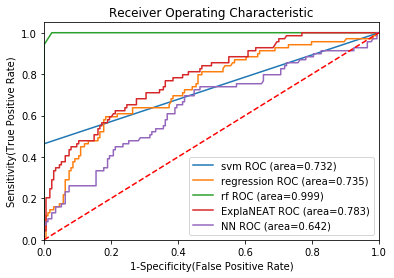

In [137]:
train_preds = {
    'svm': svm_model.predict(X_train),
    'regression': regression_model.predict(X_train),
    'rf': rf.predict(X_train),
    'ExplaNEAT': [bestNet.activate(x)[0] for x in X_train],
    'NN': torch.sigmoid( nn_model.forward(torch.from_numpy(X_train).float().to(cuda_device)).to(device)).detach().numpy()
}

plt.figure()
for model, preds in train_preds.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_train, preds)
    auc = metrics.roc_auc_score(y_train, preds)
    plt.plot(fpr, tpr, label='%s ROC (area=%0.3f)' % (model, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

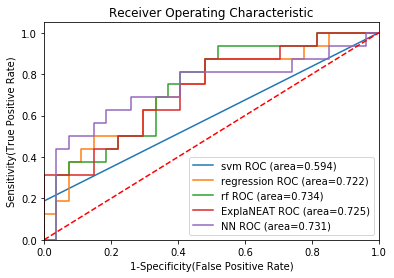

In [138]:
test_preds = {
    'svm': svm_model.predict(X_test),
    'regression': regression_model.predict(X_test),
    'rf': rf.predict(X_test),
    'ExplaNEAT': [bestNet.activate(x)[0] for x in X_test],
    'NN': torch.sigmoid( nn_model.forward(torch.from_numpy(X_test).float().to(cuda_device)).to(device)).detach().numpy()
}

plt.figure()
for model, preds in test_preds.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr, tpr, label='%s ROC (area=%0.3f)' % (model, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

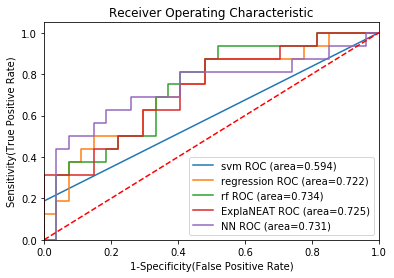

In [139]:
all_preds = {
    'svm': svm_preds,
    'regression': regression_preds,
    'rf': rf_preds,
    'ExplaNEAT': explaneat_preds,
    'NN': torch.sigmoid( nn_model.forward(torch.from_numpy(X_test).float().to(cuda_device)).to(device)).detach().numpy()
}

plt.figure()
for model, preds in all_preds.items():
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr, tpr, label='%s ROC (area=%0.3f)' % (model, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [140]:
for model, preds in all_preds.items():
    print(model)
    print(len(preds))
    print(metrics.roc_auc_score(y_test, preds))

svm
43
0.59375
regression
43
0.7222222222222222
rf
43
0.7337962962962964
ExplaNEAT
43
0.7245370370370371
NN
43
0.7314814814814815
